In [104]:
# initialize dependencies
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms
import random

Label: Rubber_Duck


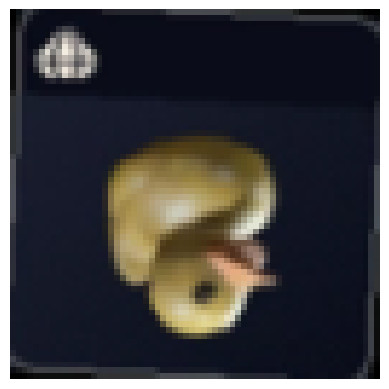

In [ ]:
# prepare datasets
# import png images from 'arc-raiders-items' folder. Label is folder name, images below are training images.
train_dataset = torchvision.datasets.ImageFolder(
    root="./arc-raiders-items",
    transform=transforms.Compose(
        [transforms.Resize((64, 64)), transforms.ToTensor()]
    ),
)

# display random image from dataset to ensure it has loaded properly
index = random.randrange(0, len(train_dataset) - 1)
image, label = train_dataset[index]
print(f"Label: {train_dataset.classes[label]}")

import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0))  # change from CxHxW to HxWxC
plt.axis("off")
plt.show()

In [ ]:
# init neuralnet
net = nn.Sequential(
    nn.Flatten(), # flatten image to 1d vector
    nn.Linear(64 * 64 * 3, 128), # input layer -> 128 neuron hidden layer
    nn.ReLU(), # activation
    nn.Dropout(0.2), # dropout for robustness i think
    nn.Linear(128, len(train_dataset.classes)), # output layer -> number of classes (categories of images)
)

loss_fn = nn.CrossEntropyLoss() # standard loss function for multi-class classification
optimizer = torch.optim.Adam(net.parameters(), lr=0.00005) # Adam optimizer with low learning rate

# move dataset to GPU if available
train_dataset = [(image.to(device), label) for image, label in train_dataset]  

# make sure we're using the GPU becasue this shit takes forever otherwise
torch.cuda.list_gpu_processes()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=12288, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=128, out_features=190, bias=True)
)

In [ ]:
# training loop

num_epochs = 100
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

for epoch in range(num_epochs):
    for images, labels in train_loader:

        # forward pass (make a prediction)
        logits = net(images.to(device))
        loss = loss_fn(logits, labels.to(device))

        # good old fashioned back propogation 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

net.eval()

Epoch [1/100], Loss: 4.9905
Epoch [2/100], Loss: 4.3888
Epoch [3/100], Loss: 4.0478
Epoch [4/100], Loss: 3.3392
Epoch [5/100], Loss: 3.0831
Epoch [6/100], Loss: 2.5926
Epoch [7/100], Loss: 2.2009
Epoch [8/100], Loss: 1.8982
Epoch [9/100], Loss: 1.8569
Epoch [10/100], Loss: 1.7599
Epoch [11/100], Loss: 1.4170
Epoch [12/100], Loss: 1.3326
Epoch [13/100], Loss: 1.0777
Epoch [14/100], Loss: 0.9959
Epoch [15/100], Loss: 0.7639
Epoch [16/100], Loss: 0.8448
Epoch [17/100], Loss: 0.7112
Epoch [18/100], Loss: 0.8162
Epoch [19/100], Loss: 0.5652
Epoch [20/100], Loss: 0.4558
Epoch [21/100], Loss: 0.5001
Epoch [22/100], Loss: 0.3555
Epoch [23/100], Loss: 0.2375
Epoch [24/100], Loss: 0.2043
Epoch [25/100], Loss: 0.2222
Epoch [26/100], Loss: 0.1887
Epoch [27/100], Loss: 0.2851
Epoch [28/100], Loss: 0.3124
Epoch [29/100], Loss: 0.2034
Epoch [30/100], Loss: 0.1780
Epoch [31/100], Loss: 0.1599
Epoch [32/100], Loss: 0.1666
Epoch [33/100], Loss: 0.2008
Epoch [34/100], Loss: 0.1040
Epoch [35/100], Loss: 0

# mostly util stuff below this

Predicted: [128, 107, 63, 4, 119], Actual: [128, 107, 63, 4, 119]


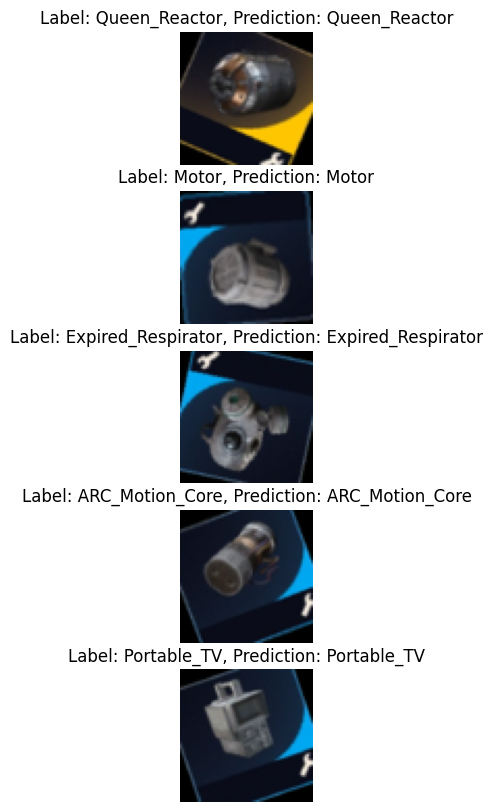

In [120]:
# predict on random images
# select random image set and predict
randomIndices = [random.randrange(0, len(train_dataset)) for _ in range(5)]
images = []
labels = []
for i in range(5):
    img, lbl = train_dataset[randomIndices[i]]
    images.append(img)
    labels.append(lbl)

# infer on GPU

images = torch.stack(images).to(device)  # create batch
logits = net(images)
predicted_labels = logits.argmax(dim=1).tolist()

# Get class names from ImageFolder
dataset_classes = torchvision.datasets.ImageFolder(root="./arc-raiders-items").classes

# visualise predictions
fig, axes = plt.subplots(5, 1, figsize=(10, 10))
print(f"Predicted: {predicted_labels}, Actual: {labels}")
cnt = 0
for ax in axes:
    img, lbl = train_dataset[randomIndices[cnt]]
    cnt += 1
    ax.imshow(img.permute(1, 2, 0).cpu())  # change from CxHxW to HxWxC
    # convert labels to category names
    train_label_name = dataset_classes[lbl]
    predicted_label_name = dataset_classes[predicted_labels[cnt-1]]
    ax.set_title(f"Label: {train_label_name}, Prediction: {predicted_label_name}")
    ax.axis("off")

In [134]:
net.eval()

net.cpu()

# Save neural net weights
torch.save(net.state_dict(), "arcraiders_model.pth")

# save ONNX
dummy_input = torch.randn(1, 3, 64, 64)
torch.onnx.export(net, dummy_input, "arcraiders_model.onnx")

[torch.onnx] Obtain model graph for `Sequential([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Sequential([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 20},
            producer_name='pytorch',
            producer_version='2.9.1+cu128',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[1,3,64,64]>
            ),
            outputs=(
                %"linear_1"<FLOAT,[1,190]>
            ),
            initializers=(
                %"1.weight"<FLOAT,[128,12288]>{TorchTensor(...)},
                %"1.bias"<FLOAT,[128]>{TorchTensor(...)},
                %"4.weight"<FLOAT,[190,128]>{TorchTensor(...)},
                %"4.bias"<FLOAT,[190]>{TorchTensor(...)},
                %"val_3"<INT64,[2]>{Tensor<INT64,[2]>(array([    1, 12288]), name='val_3')}
            ),
        ) {
            0 |  # node_view
                 %"view"<FLOAT,[1,12288]> ⬅️ ::Reshape(%"input", %"val_3"{[1, 12288]}) {allowzero=1}
            1 |  # node_linea

CPU inference time: 0.010708 seconds
Predicted: [112, 75, 62, 151, 141], Actual: [112, 75, 62, 151, 141]


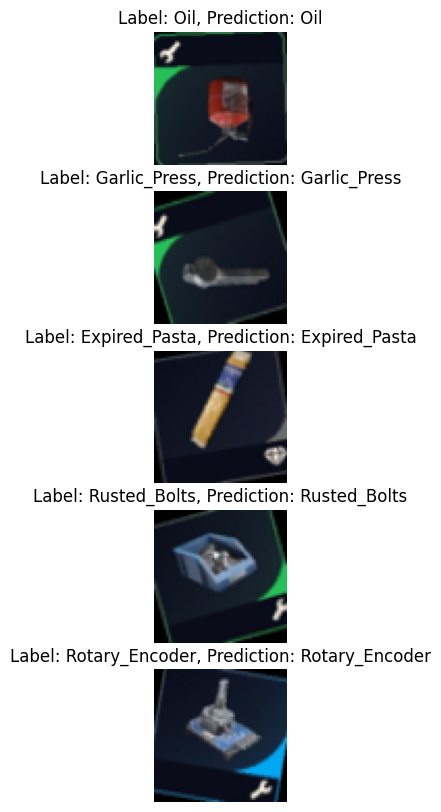

In [ ]:
# test CPU inference speed
import time

# import net from file init datasets
dataset_classes = torchvision.datasets.ImageFolder(root="./arc-raiders-items").classes

cpunet = nn.Sequential(
    nn.Flatten(),
    nn.Linear(64 * 64 * 3, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, len(dataset_classes)),
)
cpunet.load_state_dict(torch.load("arcraiders_model.pth"))
cpunet.to("cpu")

# prepare random input
cpuRandomIndices = [random.randrange(0, len(train_dataset)) for _ in range(5)]
cpuImages = []
cpuLabels = []
for i in range(5):
    img, lbl = train_dataset[cpuRandomIndices[i]]
    cpuImages.append(img)
    cpuLabels.append(lbl)
# warm up
_ = cpunet(random_input)
# measure time
start_time = time.time()
_ = cpunet(random_input)
end_time = time.time()
print(f"CPU inference time: {end_time - start_time:.6f} seconds")

# infer on GPU

cpuImages = torch.stack(cpuImages) # create batch
cpuLogits = net(cpuImages)
cpu_predicted_labels = cpuLogits.argmax(dim=1).tolist()

# visualise predictions
fig, axes = plt.subplots(5, 1, figsize=(10, 10))
print(f"Predicted: {cpu_predicted_labels}, Actual: {cpuLabels}")
cnt = 0
for ax in axes:
    img, lbl = train_dataset[cpuRandomIndices[cnt]]
    cnt += 1
    ax.imshow(img.permute(1, 2, 0).cpu())  # change from CxHxW to HxWxC
    # convert labels to category names
    train_label_name = dataset_classes[lbl]
    predicted_label_name = dataset_classes[cpu_predicted_labels[cnt-1]]
    ax.set_title(f"Label: {train_label_name}, Prediction: {predicted_label_name}")
    ax.axis("off")